In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
import statsmodels.api as sm
import glob
from pathlib import Path
import json
import os

In [86]:
def load_path_from_config(config_file='config.json'):
    """
    Load the data path from a JSON configuration file.

    Parameters:
    - config_file (str): Path to the JSON configuration file.

    Returns:
    - str: The data path specified in the configuration file.

    Raises:
    - FileNotFoundError: If the configuration file does not exist.
    - KeyError: If 'data_path' key is not found in the configuration file.
    """
    config_path = Path(config_file)
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file '{config_file}' not found.")

    with open(config_path, 'r') as f:
        config = json.load(f)

    if 'data_path' not in config:
        raise KeyError("'data_path' key not found in the configuration file.")

    return config['data_path']

def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def get_neuron_profile(file_path):
    """
    Extracts neuron tuning profiles from a single HDF5 session file.

    Parameters:
    - file_path: str, path to the .h5 file

    Returns:
    - neuron_profile: pd.DataFrame with tuning betas, p-values, and metadata
    """
    # Load firing rates and metadata
    fr_CdN = pull_from_h5(file_path, 'CdN_zFR')
    fr_OFC = pull_from_h5(file_path, 'OFC_zFR')
    firing_rates = np.concatenate([fr_CdN, fr_OFC], axis=2)

    u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'),
                              pull_from_h5(file_path, 'OFC_u_names')], axis=0)

    n_CdN = fr_CdN.shape[2]
    n_OFC = fr_OFC.shape[2]
    brain_areas = np.concatenate([np.zeros(n_CdN), np.ones(n_OFC)]).astype(int)

    u_locations = np.concatenate([pull_from_h5(file_path, 'CdN_locations'),
                                  pull_from_h5(file_path, 'OFC_locations')], axis=0)

    bhv = pd.read_hdf(file_path, key='bhv')
    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    # Trial selection
    trials2keep = bhv['n_sacc'] > 0
    bhv = bhv.loc[trials2keep]
    firing_rates = firing_rates[trials2keep, :, :]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Best-choice trials
    mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
    trial_profile = bhv[mask].reset_index()
    firing_rates = firing_rates[mask.values, :, :]

    mean_FR = firing_rates.mean(axis=1)  # shape: (n_trials, n_units)
    n_units = mean_FR.shape[1]

    # GLM design matrix
    df = pd.DataFrame({
        'value': trial_profile['ch_val'].values,
        'state': trial_profile['state'].values
    })
    state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
    df = pd.concat([df, state_dummies], axis=1)

    df['state_value_1'] = df['value'] * df['state_1']
    df['state_value_2'] = df['value'] * df['state_2']
    df['state_value_3'] = df['value'] * df['state_3']

    tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
                   'state_value_1', 'state_value_2', 'state_value_3']
    X = df[tuning_cols].astype(int)
    X = sm.add_constant(X)

    # Fit GLM for each neuron
    beta_dict = {col: [] for col in X.columns}
    pval_dict = {col: [] for col in X.columns}

    for i in range(n_units):
        y = mean_FR[:, i]
        model = sm.OLS(y, X).fit()
        for col in X.columns:
            beta_dict[col].append(model.params[col])
            pval_dict[col].append(model.pvalues[col])

    # Assemble neuron profile
    neuron_profile = pd.DataFrame({
        'neuron': u_names,
        'brain_area': brain_areas,
        'lateral': u_locations[:, 0],
        'depth': u_locations[:, 1],
        **{f'{col}_beta': beta_dict[col] for col in X.columns},
        **{f'{col}_pval': pval_dict[col] for col in X.columns}
    })

    return neuron_profile, firing_rates, trial_profile

def print_data_structure(neuron_profile, firing_rates, trial_profile):
    print(f'Shape of neuron_profile: {neuron_profile.shape}')
    print(f'Shape of firing_rates: {firing_rates.shape}')
    print(f'Shape of trial_profile: {trial_profile.shape}')
    print(f'Number of neurons: {neuron_profile.shape[0]}')
    print(f'Number of trials: {firing_rates.shape[0]}')
    print(f'Number of time points: {firing_rates.shape[1]}')

In [87]:
data_dir = load_path_from_config()
data_files = find_h5_files(data_dir)
for f in data_files:
    print(f)

file_path = data_files[0]
print(f"Using file: {file_path.split(os.sep)[-1]}")

D:/Projects/rotation_project/data2analyze\D20231219_Rec05.h5
D:/Projects/rotation_project/data2analyze\D20231221_Rec06.h5
D:/Projects/rotation_project/data2analyze\D20231224_Rec07.h5
D:/Projects/rotation_project/data2analyze\D20231227_Rec08.h5
D:/Projects/rotation_project/data2analyze\K20240707_Rec06.h5
D:/Projects/rotation_project/data2analyze\K20240710_Rec07.h5
D:/Projects/rotation_project/data2analyze\K20240712_Rec08.h5
D:/Projects/rotation_project/data2analyze\K20240715_Rec09.h5
Using file: D20231219_Rec05.h5


In [88]:
neuron_profile, firing_rates, trial_profile = get_neuron_profile(file_path)
print_data_structure(neuron_profile, firing_rates, trial_profile)

Shape of neuron_profile: (787, 20)
Shape of firing_rates: (582, 81, 787)
Shape of trial_profile: (582, 32)
Number of neurons: 787
Number of trials: 582
Number of time points: 81


In [89]:
trial_profile.head()

,index,Unnamed: 0,fname,tnum,use,state,state_cue,forced,l_val,r_val,...,sacc2_side,sacc3_t,sacc3_val,sacc3_side,sacc4_t,sacc4_val,sacc4_side,sacc5_t,sacc5_val,sacc5_side
0,1,1,D20231219,1.0,1.0,1.0,2.0,1.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,D20231219,2.0,1.0,2.0,1.0,0.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,D20231219,3.0,1.0,1.0,2.0,0.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,D20231219,4.0,1.0,1.0,2.0,0.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,7,D20231219,7.0,1.0,3.0,2.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
state_3_mask = trial_profile['state'] == 3.0
state_3_trials = trial_profile[state_3_mask]
firing_rates_state_3 = firing_rates[state_3_mask.values, :, :]
print_data_structure(neuron_profile, firing_rates_state_3, state_3_trials) 

Shape of neuron_profile: (787, 20)
Shape of firing_rates: (214, 81, 787)
Shape of trial_profile: (214, 32)
Number of neurons: 787
Number of trials: 214
Number of time points: 81


In [91]:
num_neurons = neuron_profile.shape[0]
num_timepoints = firing_rates_state_3.shape[1]
num_trials = firing_rates_state_3.shape[0]

X = state_3_trials['ch_val'].values.reshape(-1, 1)
X -= X.mean(axis=0, keepdims=True)

Y = firing_rates_state_3.reshape(num_trials, -1)
Y -= Y.mean(axis=0, keepdims=True) 

XtX_inv = np.linalg.inv(X.T @ X)
XtY = X.T @ Y                   
beta_flat = XtX_inv @ XtY       

# Reshape outputs 
beta = beta_flat.reshape(num_timepoints, num_neurons).T
intercepts = Y.mean(axis=0).reshape(num_timepoints, num_neurons).T - X.mean() * beta

In [92]:
beta_df = pd.DataFrame(beta, columns=[f'T_{i}' for i in range(num_timepoints)])
neuron_profile = pd.concat([neuron_profile, beta_df], axis=1)
neuron_profile.head()

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,T_71,T_72,T_73,T_74,T_75,T_76,T_77,T_78,T_79,T_80
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,-0.209555,0.073203,-0.107952,-0.002444,-0.099159,0.022040,...,0.005541,-0.034140,-0.056720,-0.066465,-0.066465,-0.039204,-0.084235,-0.095191,-0.088376,-0.091804
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,-0.098001,0.031881,-0.026236,0.009821,-0.081586,0.009982,...,-0.078394,-0.007456,0.069979,-0.023253,-0.043700,-0.032554,-0.043700,-0.012106,0.047982,0.051180
2,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.003928,-0.001495,-0.023993,0.072596,-0.052531,0.013681,...,-0.000941,-0.000941,-0.020111,-0.020111,-0.020111,-0.011466,0.016348,0.016348,0.016348,0.010272
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,0.107467,-0.035350,0.017201,0.091929,-0.001663,-0.009664,...,0.010035,-0.062616,-0.117175,-0.124596,-0.166716,-0.177388,-0.148624,-0.021696,0.032580,0.137953
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,0.586666,-0.184180,0.361736,0.341579,-0.116649,-0.118231,...,-0.384438,-0.485774,-0.346048,-0.314282,-0.420349,-0.257373,-0.277424,-0.271567,-0.178161,-0.230218


In [93]:
sorted_neuron_profile = neuron_profile.sort_values(by='depth', ascending=True).reset_index(drop=True)

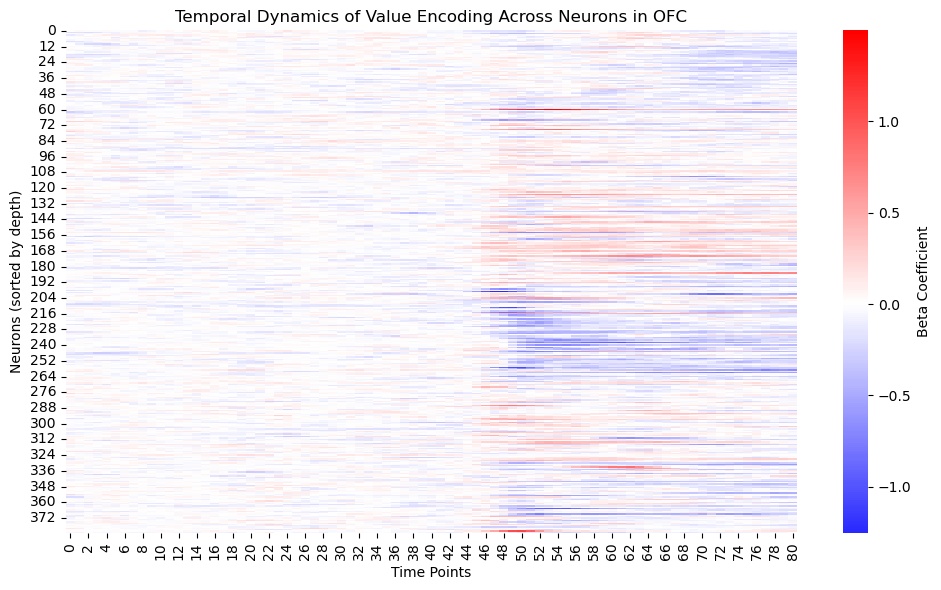

In [94]:
brain_area = 1
brain_area_mask = sorted_neuron_profile['brain_area'] == brain_area
beta_columns = [f'T_{i}' for i in range(num_timepoints)]
beta_matrix = sorted_neuron_profile[brain_area_mask][beta_columns].values

plt.figure(figsize=(10, 6))
sns.heatmap(beta_matrix, cmap='bwr', center=0, cbar_kws={'label': 'Beta Coefficient'})
plt.xlabel('Time Points')
plt.ylabel('Neurons (sorted by depth)')
plt.title('Temporal Dynamics of Value Encoding Across Neurons in OFC')
plt.tight_layout()
plt.show()

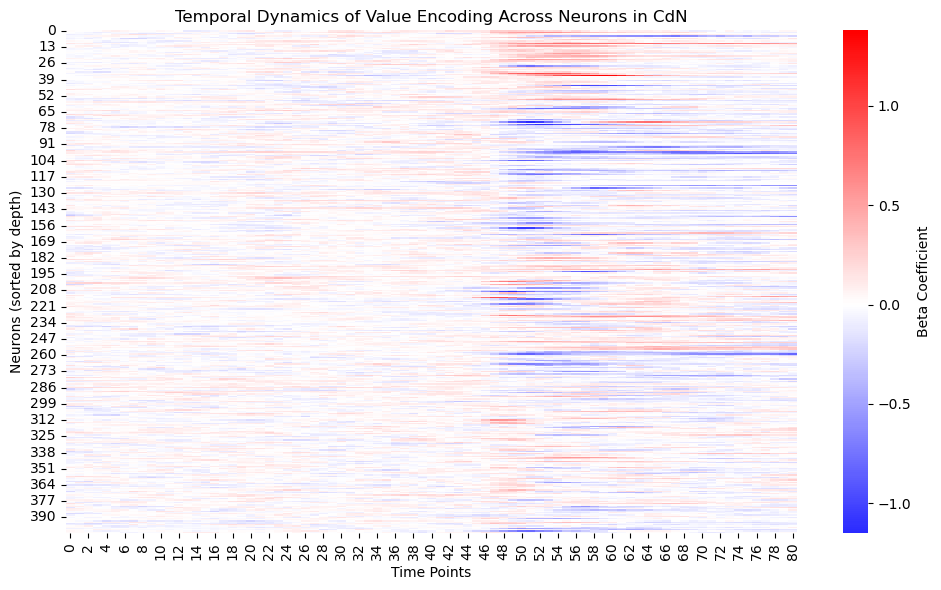

In [95]:
brain_area = 0
brain_area_mask = sorted_neuron_profile['brain_area'] == brain_area
beta_columns = [f'T_{i}' for i in range(num_timepoints)]
beta_matrix = sorted_neuron_profile[brain_area_mask][beta_columns].values

plt.figure(figsize=(10, 6))
sns.heatmap(beta_matrix, cmap='bwr', center=0, cbar_kws={'label': 'Beta Coefficient'})
plt.xlabel('Time Points')
plt.ylabel('Neurons (sorted by depth)')
plt.title('Temporal Dynamics of Value Encoding Across Neurons in CdN')
plt.tight_layout()
plt.show()

In [96]:
neuron_profile 

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,T_71,T_72,T_73,T_74,T_75,T_76,T_77,T_78,T_79,T_80
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,-0.209555,0.073203,-0.107952,-0.002444,-0.099159,0.022040,...,0.005541,-0.034140,-0.056720,-0.066465,-0.066465,-0.039204,-0.084235,-0.095191,-0.088376,-0.091804
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,-0.098001,0.031881,-0.026236,0.009821,-0.081586,0.009982,...,-0.078394,-0.007456,0.069979,-0.023253,-0.043700,-0.032554,-0.043700,-0.012106,0.047982,0.051180
2,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.003928,-0.001495,-0.023993,0.072596,-0.052531,0.013681,...,-0.000941,-0.000941,-0.020111,-0.020111,-0.020111,-0.011466,0.016348,0.016348,0.016348,0.010272
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,0.107467,-0.035350,0.017201,0.091929,-0.001663,-0.009664,...,0.010035,-0.062616,-0.117175,-0.124596,-0.166716,-0.177388,-0.148624,-0.021696,0.032580,0.137953
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,0.586666,-0.184180,0.361736,0.341579,-0.116649,-0.118231,...,-0.384438,-0.485774,-0.346048,-0.314282,-0.420349,-0.257373,-0.277424,-0.271567,-0.178161,-0.230218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,b'D20231219_Rec05_OFC_u565',1,-0.692354,3792.714077,0.063593,-0.028176,0.098272,-0.004537,-0.030143,0.009741,...,-0.080648,-0.059916,-0.041316,0.016531,0.032301,0.034159,0.011126,-0.035827,-0.048051,-0.067361
783,b'D20231219_Rec05_OFC_u566',1,-11.716311,3752.252066,-0.020885,0.001855,-0.110876,0.123807,-0.033816,0.007843,...,-0.016703,-0.051727,0.001808,0.075683,-0.003584,0.048416,0.017060,-0.023609,-0.002039,-0.029208
784,b'D20231219_Rec05_OFC_u567',1,105.845457,3796.256082,-0.002208,0.001986,-0.061156,0.060005,-0.001058,0.008939,...,-0.025963,-0.025963,-0.013966,-0.035008,-0.025963,-0.016918,-0.050942,-0.061956,-0.075922,-0.098604
785,b'D20231219_Rec05_OFC_u568',1,88.446736,3801.910258,0.053250,-0.025483,-0.081495,-0.037843,0.172588,0.000668,...,0.010025,-0.007235,0.026417,-0.000641,0.016268,0.086774,0.116871,0.154511,0.136301,0.111097


In [97]:
neuron_profile.head()

,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,state_3_beta,state_value_1_beta,...,T_71,T_72,T_73,T_74,T_75,T_76,T_77,T_78,T_79,T_80
0,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,-0.209555,0.073203,-0.107952,-0.002444,-0.099159,0.022040,...,0.005541,-0.034140,-0.056720,-0.066465,-0.066465,-0.039204,-0.084235,-0.095191,-0.088376,-0.091804
1,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,-0.098001,0.031881,-0.026236,0.009821,-0.081586,0.009982,...,-0.078394,-0.007456,0.069979,-0.023253,-0.043700,-0.032554,-0.043700,-0.012106,0.047982,0.051180
2,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.003928,-0.001495,-0.023993,0.072596,-0.052531,0.013681,...,-0.000941,-0.000941,-0.020111,-0.020111,-0.020111,-0.011466,0.016348,0.016348,0.016348,0.010272
3,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,0.107467,-0.035350,0.017201,0.091929,-0.001663,-0.009664,...,0.010035,-0.062616,-0.117175,-0.124596,-0.166716,-0.177388,-0.148624,-0.021696,0.032580,0.137953
4,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,0.586666,-0.184180,0.361736,0.341579,-0.116649,-0.118231,...,-0.384438,-0.485774,-0.346048,-0.314282,-0.420349,-0.257373,-0.277424,-0.271567,-0.178161,-0.230218


In [98]:
triel2plot = 0
brain_area = 1  # 0 for CdN, 1 for OFC
trial_firing_rate = firing_rates[triel2plot, :, :]
neuron_profile = neuron_profile.sort_values(by='depth', ascending=True).reset_index(drop=True)
brain_area_mask = neuron_profile['brain_area'] == brain_area
brain_area_neurons = neuron_profile[brain_area_mask].reset_index(drop=True)